In [1]:
import irtk
from irtk.scene import *
from irtk.renderer import Renderer
from irtk.io import write_image
from irtk.utils import apply_pmkmp_cm

from IPython.display import Image, display
from pathlib import Path 

data_path = Path('../data')

/home/nick/miniconda3/envs/pbir-nie/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
scene = Scene()
scene.set('armadillo', Mesh.from_file(data_path / 'meshes' / 'armadillo.obj', mat_id='blue'))
scene.set('blue', MicrofacetBRDF((0.2, 0.2, 0.9), (0.04, 0.04, 0.04), 0.7))
scene.set('envlight', EnvironmentLight.from_file(data_path / 'envmaps' / 'factory.exr'))
scene.set('sensor', PerspectiveCamera.from_lookat(fov=40, origin=(0, 0, 2), target=(0, 0, 0), up=(0, 1, 0)))
scene.set('film', HDRFilm(width=512, height=512))
scene.set('integrator', Integrator(type='path', config={
    'max_depth': 1,
    'hide_emitters': False
}))
print(scene)

armadillo:
----
v:
	description: mesh vertex positions
	is differentiable: True
	requires grad: False
	value: 	tensor([[ 0.0414, -0.1924, -0.1188],
        [ 0.0353, -0.1864, -0.1199],
        [ 0.0409, -0.1873, -0.1259],
        ...,
        [-0.4123,  0.3096,  0.2094],
        [-0.4167,  0.2992,  0.2206],
        [-0.4152,  0.3048,  0.2151]], device='cuda:0')
f:
	description: mesh face indices
	is differentiable: False
	value: 	tensor([[    0,     1,     2],
        [    0,     3,     1],
        [    1,     4,     2],
        ...,
        [26444, 26442, 26441],
        [26444, 26436, 26442],
        [26444, 26443, 26437]], device='cuda:0', dtype=torch.int32)
uv:
	description: mesh uv coordinates
	is differentiable: False
	value: 	tensor([[0.0864, 0.8973],
        [0.0831, 0.8967],
        [0.0862, 0.8928],
        ...,
        [0.7044, 0.8980],
        [0.6640, 0.9172],
        [0.8925, 0.3547]], device='cuda:0')
fuv:
	description: mesh uv face indices
	is differentiable: False
	val

In [3]:
# scene = Scene()
# scene.set('armadillo', Mesh.from_file(data_path / 'meshes' / 'armadillo.obj', mat_id='blue'))
# scene.set('blue', DiffuseBRDF((0.2, 0.2, 0.9)))
# scene.set('sensor', PerspectiveCamera.from_lookat(fov=40, origin=(1.5, 0, 1.5), target=(0, 0, 0), up=(0, 1, 0)))
# scene.set('film', HDRFilm(width=512, height=512))
# scene.set('integrator', Integrator(type='collocated', config={
#     'intensity': 10,
# }))
# print(scene)

In [4]:
print(irtk.get_connector_list())

['psdr_jit']


In [5]:
connector = irtk.get_connector('psdr_jit')

In [6]:
npass = 10

In [7]:
render_options = {
    'spp': 64,
    'sppe': 0,
    'sppse': 0,
    'log_level': 0,
    'npass': npass
}

image_interior, grad_image_interior = connector.forward_ad_mesh_translation('armadillo', scene, render_options)
grad_image_full = grad_image_interior
grad_image_interior = apply_pmkmp_cm(grad_image_interior, -2, 2)

In [8]:
render_options = {
    'spp': 0,
    'sppe': 16,
    'sppse': 0,
    'log_level': 0,
    'npass': npass
}

image_primary, grad_image_primary = connector.forward_ad_mesh_translation('armadillo', scene, render_options)
grad_image_full += grad_image_primary
grad_image_primary = apply_pmkmp_cm(grad_image_primary, -2, 2)

In [9]:
render_options = {
    'spp': 0,
    'sppe': 0,
    'sppse': 16,
    'log_level': 0,
    'npass': npass
}

image_secondary, grad_image_secondary = connector.forward_ad_mesh_translation('armadillo', scene, render_options)
grad_image_full += grad_image_secondary
grad_image_secondary = apply_pmkmp_cm(grad_image_secondary, -2, 2)

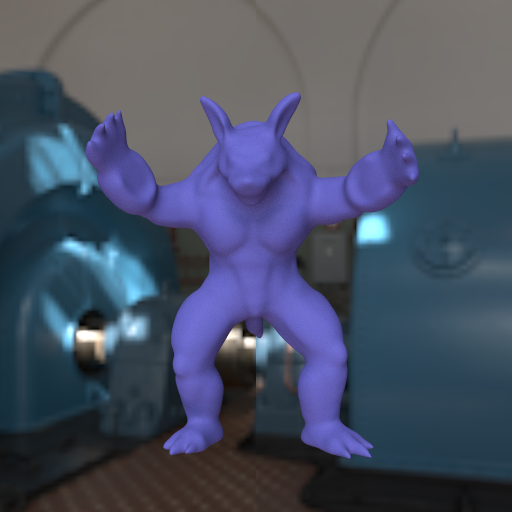

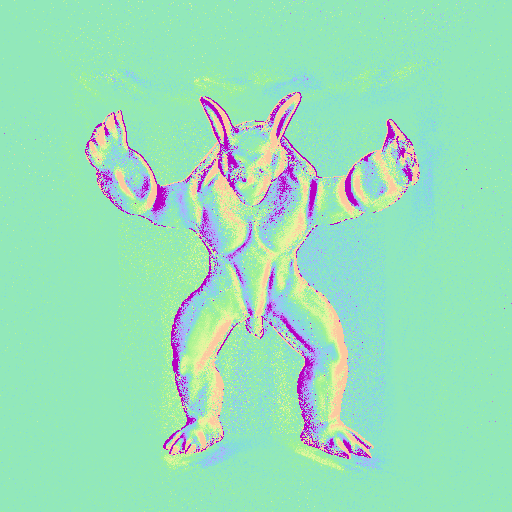

In [10]:
image_full = image_interior + image_primary + image_secondary
grad_image_full = apply_pmkmp_cm(grad_image_full, -2, 2)

write_image('original.png', image_full)
display(Image('original.png'))

write_image('grad.png', grad_image_full)
display(Image('grad.png'))

write_image('grad_interior.png', grad_image_interior)
write_image('grad_primary.png', grad_image_primary)
write_image('grad_secondary.png', grad_image_secondary)


In [11]:
# Add guiding to the secondary boundary term

render_options = {
    'spp': 0,
    'sppe': 0,
    'sppse': 16,
    'log_level': 0,
    'npass': npass,
    'guiding_options': {
        'type': 'grid',
        'res': [2000, 5, 5, 32],
        'nrounds': 1
    }
}

image_secondary, grad_image_secondary_guided = connector.forward_ad_mesh_translation('armadillo', scene, render_options)
grad_image_secondary_guided = apply_pmkmp_cm(grad_image_secondary_guided, -2, 2)
write_image('grad_secondary_guided.png', grad_image_secondary_guided)

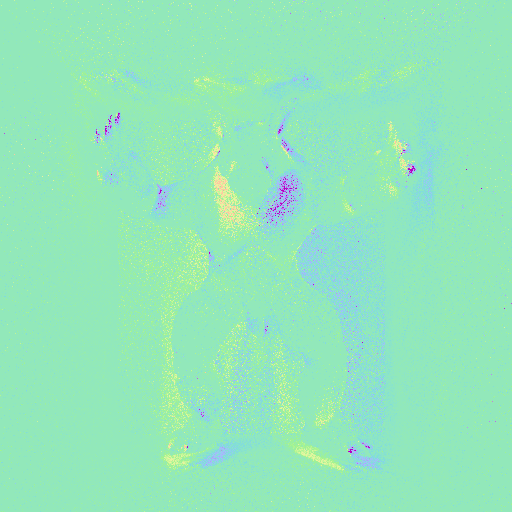

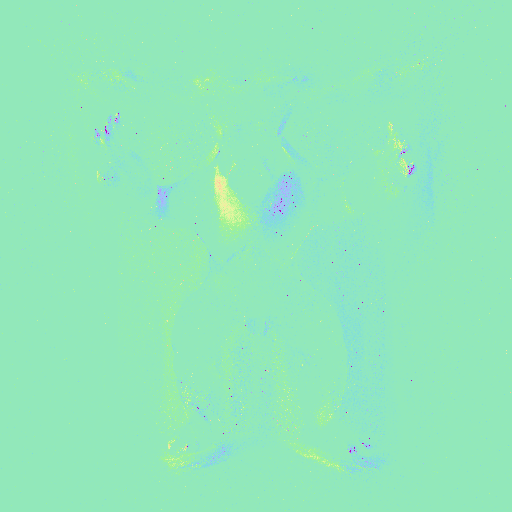

In [12]:
display(Image('grad_secondary.png'))
display(Image('grad_secondary_guided.png'))